In [23]:
import pickle
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import os


# pkl 파일을 열고 객체를 불러오는 함수
def load_pickle(file_path):
    with open(file_path, 'rb') as f:  # 'rb'는 바이너리 읽기 모드
        data = pickle.load(f)  # pickle.load를 사용해 파일 내용 불러오기
    return data

# 예시: 'example.pkl' 파일을 불러오기
file_path = '/data/ephemeral/home/mmdetection/result_ddq61_eval.pkl'
loaded_data = load_pickle(file_path)

## 1. 예측 box 시각화

In [58]:
from pycocotools.coco import COCO
import cv2
import numpy as np
import matplotlib.pyplot as plt

classes = {0:"general trash",1:"Paper",2:"Paper pack",3:"Metal",4:"Glass",5:"Plastic",6:"Styrofoam",7:"Plastic bag",8:"Battery",9:"Clothing"}
output_dir = 'results/ddq_eval0'
os.makedirs(output_dir, exist_ok=True)

def visulize(img_info,pred,gt,data_root='../dataset',threshold=0.3):
    file_name = os.path.join(data_root,img_info['file_name'])
    img = np.array(cv2.imread(file_name))
    if img is None:
        print(f"Unable to read image: {file_name}")
    
    thresholds = pred['pred_instances']['scores']>threshold
    labels = pred['pred_instances']['labels'][thresholds]
    boxes = pred['pred_instances']['bboxes'][thresholds]
    confidences = pred['pred_instances']['scores'][thresholds]

    for label,k,confidence in zip(labels,boxes,confidences):
        label_num = int(label)  # 첫 번째 요소를 라벨로 사용
        label = classes[label_num]
        confidence = float(confidence)  # 두 번째 요소를 신뢰도로 사용
        pt1 = (int(float(k[0])), int(float(k[1])))
        pt2 = (int(float(k[2])), int(float(k[3])))
        
        # 바운딩 박스 그리기
        cv2.rectangle(img, pt1, pt2, (0, 255, 0), 2)
        
        # 라벨 텍스트 준비
        label_text = f"{label}: {confidence:.2f}"
        
        # 라벨 배경 크기 계산
        text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        
        # 라벨 배경 그리기
        cv2.rectangle(img, 
                    (pt1[0], pt1[1] - text_size[1] - 4), 
                    (pt1[0] + text_size[0], pt1[1]), 
                    (0, 255, 0), 
                    -1)
        
        # 라벨 텍스트 그리기
        cv2.putText(img, label_text, 
                    (pt1[0], pt1[1] - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

    for bbox in gt:
        label_num = bbox['category_id']
        label = classes[label_num]
        x_min = int(bbox['bbox'][0])
        y_min = int(bbox['bbox'][1])
        x_max = int(bbox['bbox'][0]+bbox['bbox'][2])
        y_max = int(bbox['bbox'][1]+bbox['bbox'][3])
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (256, 0, 0), 2)
    
            # 라벨 텍스트 준비
        label_text = f"{label}"
        
        # 라벨 배경 크기 계산
        text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        
        # 라벨 배경 그리기
        cv2.rectangle(img, 
                    (x_max - text_size[0], y_min - text_size[1] - 4), 
                    (x_max , y_min), 
                    (255, 0, 0), 
                    -1)
        
        # 라벨 텍스트 그리기
        cv2.putText(img, label_text, 
                    (x_max - text_size[0], y_min - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # 이미지 저장 (필요한 경우 주석 해제)
    i = img_info['id']
    output_path = os.path.join(output_dir, f'output_{i}.png')
    plt.imshow(img)


In [59]:
coco = COCO('../dataset/evaluation_annot.json')
img_ids = coco.getImgIds()
for id, out in zip(img_ids,loaded_data):
    image_info = coco.loadImgs(coco.getImgIds(imgIds=id))[0]
    gt_boxes = []
    for i in coco.getAnnIds(imgIds=id):
        anns = coco.loadAnns(ids = i)
        gt_boxes.append(anns[0])
    visulize(image_info,out,gt_boxes,threshold=0.2)
# 진행 상황 출력 (100개마다)
    if (id + 1) % 100 == 0:
        print(f"Processed {id + 1} images")

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
Processed 100 images
Processed 200 images
Processed 300 images
Processed 400 images
Processed 500 images
Processed 600 images
Processed 700 images
Processed 1100 images
Processed 1200 images
Processed 1300 images
Processed 1400 images
Processed 1500 images
Processed 1600 images
Processed 1700 images
Processed 1800 images
Processed 1900 images
Processed 2000 images
Processed 2200 images
Processed 2300 images
Processed 2400 images
Processed 2500 images
Processed 2700 images
Processed 2800 images
Processed 2900 images
Processed 3000 images
Processed 3200 images
Processed 3300 images
Processed 3500 images
Processed 3600 images
Processed 3700 images
Processed 3800 images
Processed 3900 images
Processed 4000 images
Processed 4100 images
Processed 4200 images
Processed 4300 images
Processed 4400 images
Processed 4500 images
Processed 4600 images
Processed 4700 images
Processed 4800 images


## 예측결과 mAP 계산

In [24]:
def compute_iou(pred_box, gt_box):
    # pred_box and gt_box are [x_min, y_min, x_max, y_max]
    gt_box[0] = float(gt_box[0])
    gt_box[1] = float(gt_box[1])
    gt_box_x_max = float(gt_box[0]+gt_box[2])
    gt_box_y_max = float(gt_box[1]+gt_box[3])
    
    # Intersection coordinates
    x_min = max(float(pred_box[0]), gt_box[0])
    y_min = max(float(pred_box[1]), gt_box[1])
    x_max = min(float(pred_box[2]), gt_box_x_max)
    y_max = min(float(pred_box[3]), gt_box_y_max)
    
    # Intersection area
    intersection = max(0, x_max - x_min) * max(0, y_max - y_min)
    
    # Predicted box area and Ground truth box area
    pred_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    gt_area = (gt_box_x_max - gt_box[0]) * (gt_box_y_max - gt_box[1])
    
    # Union area
    union = pred_area + gt_area - intersection
    
    # IoU calculation
    iou = intersection / union if union != 0 else 0
    return iou

def compute_precision_recall(pred_boxes, gt_boxes, iou_threshold=0.5):
    tp, fp, fn = 0, 0, 0
    matched_gt = set()  # To keep track of matched ground truth boxes
    
    for pred_box in pred_boxes:
        best_iou = 0
        best_gt_idx = -1
        
        for i, gt_box in enumerate(gt_boxes):
            iou = compute_iou(pred_box, gt_box)
            if iou > best_iou and iou >= iou_threshold and i not in matched_gt:
                best_iou = iou
                best_gt_idx = i
        
        if best_gt_idx >= 0:
            tp += 1  # True positive
            matched_gt.add(best_gt_idx)
        else:
            fp += 1  # False positive
    
    # Remaining unmatched ground truth boxes are false negatives
    fn = len(gt_boxes) - len(matched_gt)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    return precision, recall

def compute_average_precision(precisions, recalls):
    # Sort by recall
    recalls, precisions = zip(*sorted(zip(recalls, precisions)))

    ap = 0
    prev_recall = 0
    for p, r in zip(precisions, recalls):
        ap += p * (r - prev_recall)
        prev_recall = r
    
    return ap

def calculate_map(pred_boxes_list, gt_boxes_list, iou_threshold=0.5):
    all_precisions = []
    all_recalls = []

    for pred_boxes, gt_boxes in zip(pred_boxes_list, gt_boxes_list):
        precision, recall = compute_precision_recall(pred_boxes, gt_boxes, iou_threshold)
        all_precisions.append(precision)
        all_recalls.append(recall)
    mAP = compute_average_precision(all_precisions,all_recalls)
    return precision,recall, mAP


In [25]:
#전체 결과 mAP
coco = COCO('../dataset/validation_2_annot.json')
img_ids = coco.getImgIds()
maps = []
ps = []
rs = []
boxess = []
all_gts = []

iou_threshold=0.5
for id, out in zip(img_ids,loaded_data):
    gt_boxes = []
    image_info = coco.loadImgs(coco.getImgIds(imgIds=id))[0]
    for i in coco.getAnnIds(imgIds=id):
        anns = coco.loadAnns(ids = i)
        gt_boxes.append(anns[0]['bbox'])
    thresholds = out['pred_instances']['scores']>0.2
    all_gts.append(gt_boxes)
    boxess.append(out['pred_instances']['bboxes'][thresholds])
mpr,mc,mp = calculate_map(boxess,all_gts,iou_threshold)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [10]:
#후
print(mp)

0.4430398092763854


In [26]:
#전전
print(mp)

0.44485648071031136


In [9]:
#이미지별 mAP
coco = COCO('../dataset/validation_2_annot.json')
img_ids = coco.getImgIds()
maps = []
ps = []
rs = []
cs = []
iou_threshold=0.5
for id, out in zip(img_ids,loaded_data):
    image_info = coco.loadImgs(coco.getImgIds(imgIds=id))[0]
    gt_boxes = []
    for i in coco.getAnnIds(imgIds=id):
        anns = coco.loadAnns(ids = i)
        gt_boxes.append(anns[0]['bbox'])
    thresholds = out['pred_instances']['scores']>0.2
    boxes = out['pred_instances']['bboxes'][thresholds]
    p,r,c = calculate_map([boxes],[gt_boxes],iou_threshold)
    ps.append(p)
    rs.append(r)
    cs.append(c)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


## Class 별 예측율 확인

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from sklearn.metrics import accuracy_score, classification_report


def compute_labels(pred_boxes, gt_boxes, pred_labels, gt_labels, iou_threshold=0.5):
    pred,target = [],[]
    matched_gt = set()  # To keep track of matched ground truth boxes
    
    for i, gt_box in enumerate(gt_boxes):
        best_iou = 0
        best_gt_idx = -1
        
        for j, pred_box in enumerate(pred_boxes):
            iou = compute_iou(pred_box, gt_box)
            if iou > best_iou and iou >= iou_threshold and i not in matched_gt:
                best_iou = iou
                best_gt_idx = i
                best_pred_idx = j
        
        if best_gt_idx >= 0:
            pred.append(pred_labels[best_pred_idx])
            target.append(gt_labels[best_gt_idx])
            matched_gt.add(best_gt_idx)
        else:
            pred.append(10)
            target.append(gt_labels[i])

    return pred, target

def show_confusion_matrix(y_true,y_pred,classes):
    cm = confusion_matrix(y_true, y_pred).T

    # 시각화
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=[classes[i] for i in range(11)], 
                yticklabels=[classes[i] for i in range(11)])
    plt.xlabel('True Labels')
    plt.ylabel('Predicted Labels')
    plt.title('Confusion Matrix for Multi-Class Classification')
    plt.show()

def calculate_confusion_matrix(pred_boxes_list, gt_boxes_list, pred_labels_list,gt_labels_list,iou_threshold=0.5):
    classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", 
        "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing",'Miss match']

    all_preds = []
    all_targets = []

    for pred_boxes, gt_boxes, pred_labels, gt_labels in zip(pred_boxes_list, gt_boxes_list, pred_labels_list, gt_labels_list):
        pred, target = compute_labels(pred_boxes, gt_boxes, pred_labels, gt_labels, iou_threshold)
        all_preds.extend(pred)
        all_targets.extend(target)
    report = classification_report(all_targets, all_preds, target_names=[classes[i] for i in range(11)])
    show_confusion_matrix(all_targets,all_preds,classes)
    print(report)




loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


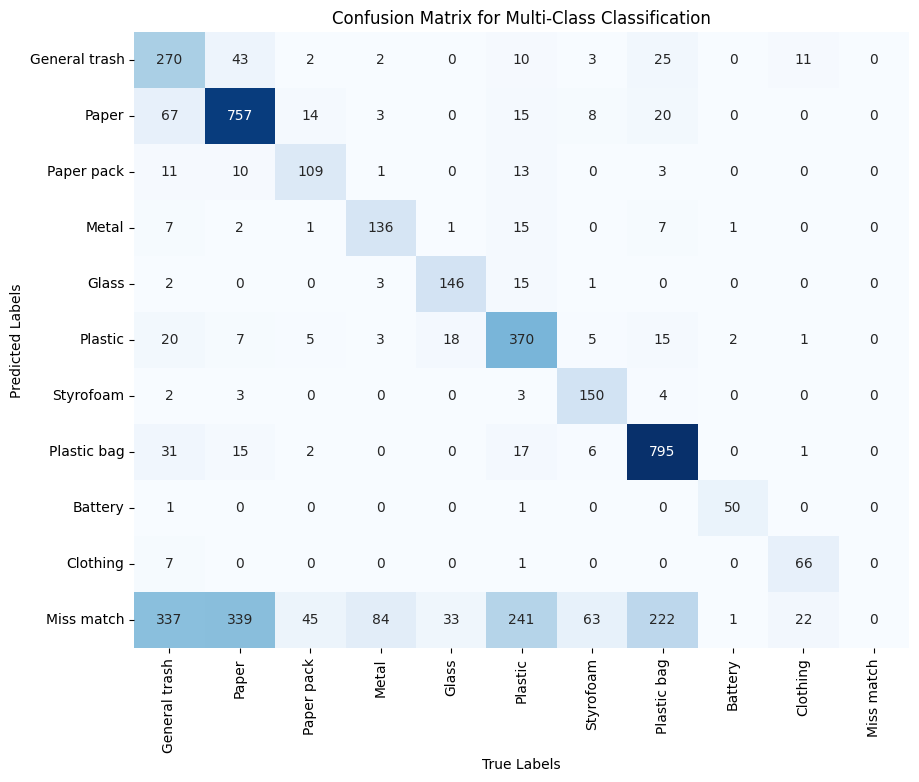

               precision    recall  f1-score   support

General trash       0.74      0.36      0.48       755
        Paper       0.86      0.64      0.73      1176
   Paper pack       0.74      0.61      0.67       178
        Metal       0.80      0.59      0.68       232
        Glass       0.87      0.74      0.80       198
      Plastic       0.83      0.53      0.65       701
    Styrofoam       0.93      0.64      0.75       236
  Plastic bag       0.92      0.73      0.81      1091
      Battery       0.96      0.93      0.94        54
     Clothing       0.89      0.65      0.75       101
   Miss match       0.00      0.00      0.00         0

     accuracy                           0.60      4722
    macro avg       0.78      0.58      0.66      4722
 weighted avg       0.85      0.60      0.70      4722



In [28]:
coco = COCO('../dataset/validation_2_annot.json')
img_ids = coco.getImgIds()
trues = []
preds = []
preds_labels = []
true_labels = []
true_boxes = []
iou_threshold=0.5
for id, out in zip(img_ids,loaded_data):
    image_info = coco.loadImgs(coco.getImgIds(imgIds=id))[0]
    gt_boxes = []
    gt_labels = []
    for i in coco.getAnnIds(imgIds=id):
        anns = coco.loadAnns(ids = i)
        gt_boxes.append(anns[0]['bbox'])
        gt_labels.append(anns[0]['category_id'])
    thresholds = out['pred_instances']['scores']>0.2
    labels = out['pred_instances']['labels'][thresholds]
    boxes = out['pred_instances']['bboxes'][thresholds]

    true_labels.append(gt_labels)
    true_boxes.append(gt_boxes)
    preds_labels.append(labels)
    preds.append(boxes)
calculate_confusion_matrix(preds,true_boxes,preds_labels,true_labels)

In [13]:
#카테고리별 mAP
def cate_mAP(catId):
    coco = COCO('../dataset/validation_2_annot.json')
    cat_img_ids = coco.getImgIds(catIds=catId)
    img_ids = coco.getImgIds()
    ps0 = []
    rs0 = []
    cs0 = []
    iou_threshold=0.5
    for id in cat_img_ids:
        gt_boxes = []
        i_id = img_ids.index(id)
        out = loaded_data[i_id]
        for i in coco.getAnnIds(imgIds=id):
            anns = coco.loadAnns(ids = i)
            gt_boxes.append(anns[0]['bbox'])
        thresholds = (out['pred_instances']['labels'] == catId) & (out['pred_instances']['scores'] > 0.2)
        boxes = out['pred_instances']['bboxes'][thresholds]
        p0,r0,c0 = calculate_map([boxes],[gt_boxes],iou_threshold)
        ps0.append(p0)
        rs0.append(r0)
        cs0.append(c0)
    return ps0,rs0,cs0

In [14]:
cat_img_ids = coco.getImgIds(catIds=0)
_,_,cs0 = cate_mAP(0)
for i,c in enumerate(cs0):
    if c==0:
        print(i, cat_img_ids[i])


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
2 4103
5 4114
10 31
14 2097
19 2114
23 2148
31 115
32 121
38 151
51 2230
54 193
74 2326
80 303
88 4417
92 329
107 4479
108 4483
112 408
114 4506
117 4526
128 4579
131 2537
136 510
139 521
141 2573
144 534
146 4637
149 4644
150 569
155 4688
162 4710
169 4738
176 4745
177 2700
180 4754
184 4782
202 759
206 2832
208 787
213 796
216 2869
218 850
222 2934
228 948
231 962
233 3021
235 3030
237 986
241 1023
242 1024
244 1046
245 3100
248 1063
249 3120
256 1120
259 1137
262 3187
288 3338
289 1296
294 3375
297 3389
301 3408
307 3430
318 3509
320 3514
324 1498
331 3572
336 1548
346 3682
349 1649
364 3809
365 1769
368 3828
375 1828
390 4007
400 4055


In [17]:
import numpy as np
def get_box(catId):
    coco = COCO('../dataset/validation_2_annot.json')
    cat_img_ids = coco.getImgIds(catIds=catId)
    img_ids = coco.getImgIds()
    gt_boxeses = []
    pred_boxeses = []
    for id in cat_img_ids:
        gt_boxes = []
        i_id = img_ids.index(id)
        out = loaded_data[i_id]
        for i in coco.getAnnIds(imgIds=id):
            anns = coco.loadAnns(ids = i)
            gt_boxes.append(anns[0]['bbox'])
        thresholds = (out['pred_instances']['labels'] == catId) & (out['pred_instances']['scores'] > 0.2)
        boxes = out['pred_instances']['bboxes'][thresholds]

        gt_boxeses.extend(gt_boxes)
        pred_boxeses.extend(boxes)
    return gt_boxeses,pred_boxeses

gt_box,pred_box = get_box(0)

def box_size(bboxes, type = None):
    box_sizes = []
    if type == 'coco':
        for i in bboxes:
            box_size = (i[2]) * (i[3])
            box_sizes.append(box_size)
    else:
        for i in bboxes:
            box_size = (i[2]-i[0]) * (i[3]-i[1])
            box_sizes.append(box_size)
    return np.mean(box_sizes)

print(box_size(gt_box,'coco'),box_size(pred_box))


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
75084.90881518269 70421.24


In [18]:
def find_mismatch(pred_boxes, gt_boxes, iou_threshold=0.5):
    box_index,target = [],[]
    matched_gt = set()  # To keep track of matched ground truth boxes
    
    for i, gt_box in enumerate(gt_boxes):
        best_iou = 0
        best_gt_idx = -1
        
        for j, pred_box in enumerate(pred_boxes):
            iou = compute_iou(pred_box, gt_box)
            if iou > best_iou and iou >= iou_threshold and i not in matched_gt:
                best_iou = iou
                best_gt_idx = j
        
        if best_gt_idx < 0:
            target.append(gt_box)
            box_index.append(i)
        else:
            matched_gt.add(best_gt_idx)

    return target,box_index


In [19]:
#카테고리별 mAP
def cate_mismatch(catId):
    coco = COCO('../dataset/validation_2_annot.json')
    cat_img_ids = coco.getImgIds(catIds=catId)
    img_ids = coco.getImgIds()
    t0 = []
    i0 = []
    iou_threshold=0.5
    for id in cat_img_ids:
        gt_boxes = []
        i_id = img_ids.index(id)
        out = loaded_data[i_id]
        for i in coco.getAnnIds(imgIds=id, catIds=catId):
            anns = coco.loadAnns(ids = i)
            gt_boxes.append(anns[0]['bbox'])
        thresholds = (out['pred_instances']['labels'] == catId) & (out['pred_instances']['scores'] > 0.2)
        boxes = out['pred_instances']['bboxes'][thresholds]
        t,bi = find_mismatch(boxes,gt_boxes,iou_threshold)
        t0.extend(t)
        i0.append(bi)
    return t0,i0

In [22]:
for i in range(10):
    t0,i0 = cate_mismatch(i)
    gt_box,pred_box = get_box(i)
    print(classes[i],box_size(gt_box,'coco'),box_size(t0,'coco'))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
general trash 75084.90881518269 42377.37328611898
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Paper 67445.81174533107 56299.74067285382
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Paper pack 59753.77255969437 42565.217
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Metal 70746.36 35754.139743589745
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
Glass